In [212]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

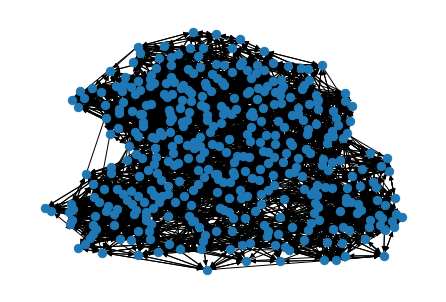

In [213]:
side = 20
sw = nx.navigable_small_world_graph(side, p=2, q=5)
options = {
#     'node_color': 'black',
    'node_size': 70,
    'width': 1,
}
nx.draw(sw, **options)

In [214]:
def vertex_num(vertex):
    return vertex[0] * 6 + vertex[1]

WARNING    "j" is an internal variable of group "synapses_2", but also exists in the run namespace with the value 999. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


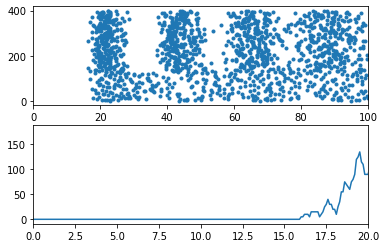

In [215]:
from brian2 import *

N = side ** 2
Vr = 10*mV
theta = 20*mV
tau = 20*ms
delta = 2*ms
taurefr = 2*ms
duration = .1*second
C = 1000
sparseness = float(C)/N
J = .1*mV
muext = 25*mV
sigmaext = 1*mV


eqs = """
dV/dt = (-V+muext + sigmaext * sqrt(tau) * xi)/tau : volt
"""

group = NeuronGroup(N, eqs, threshold='V>theta',
                    reset='V=Vr', refractory=taurefr, method='euler')
group.V = Vr

    
syn = Synapses(group, group, 'w : 1', on_pre='V += -J')
for edge in sw.edges:
    syn.connect(i=vertex_num(edge[0]), j=vertex_num(edge[1]))
    syn.w = 'j*0.2'




#conn = Synapses(group, group, on_pre='V += -J', delay=delta)
#conn.connect(p=sparseness)
M = SpikeMonitor(group)
LFP = PopulationRateMonitor(group)
net = Network(group, syn, M, LFP)
net.run(duration)

subplot(211)
plot(M.t/ms, M.i, '.')
xlim(0, duration/ms)

subplot(212)
plot(LFP.t/ms, LFP.smooth_rate(window='flat', width=0.5*ms)/Hz)
xlim(0, duration/ms/5)

show()

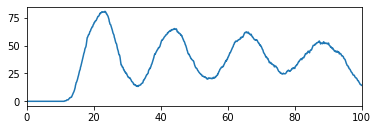

In [216]:
subplot(212)
plot(LFP.t/ms, LFP.smooth_rate(window='flat', width=10.1*ms)/Hz)
xlim(0, duration/ms)

show()

In [217]:
def find_min_max(count=4, start=20, dist=10):
    maxs = [0] * count
    mins = [float('inf')] * count
    last_max_j, last_min_j = 0, 0
    for j in range(len(LFP.smooth_rate(window='flat', width=10*ms)/Hz)):
        elem = list(LFP.smooth_rate(window='flat', width=10*ms)/Hz)[j]
        for i in range(len(maxs)):
            if j - last_max_j > dist and elem > maxs[i]:
                maxs[i + 1:] = maxs[i:-1].copy()
                maxs[i] = elem
                last_max_j = j
                break
        for i in range(len(mins)):
            if list(LFP.t/ms)[j] > start and j - last_min_j > dist and elem < mins[i]:
                mins[i + 1:] = mins[i:-1].copy()
                mins[i] = elem
                last_min_j = j
                break
    return maxs, mins
find_min_max(4)

([80.44554455445544, 79.70297029702971, 75.74257425742574, 74.25742574257426],
 [13.366336633663366,
  14.85148514851485,
  14.851485148514852,
  16.336633663366335])

In [218]:
def delete_neuron(number):
    for i in list(syn.i):
        if syn.i[i] == number:
            syn.w[i] = 0

Удаляем нейрон 1


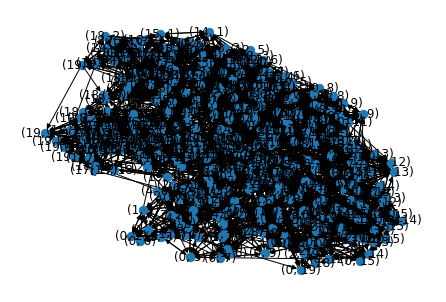

In [219]:
def delete_max_neuron():
    i = 0
    k = 0
    max_sum = 0
    summ = 0.0
    max_num = 0
    for i in range(len(syn.w)):
        if syn.i[i] == k:
            summ += syn.w[i]
        else:
            if summ > max_sum:
                max_sum = summ
                max_num = k
                k += 1
            summ = syn.w[i]
    delete_neuron(max_num)
    sw.remove_node((max_num // 6, max_num % 6))
    nx.draw(sw, with_labels=True, **options)
    print(f'Удаляем нейрон {max_num}')
delete_max_neuron()

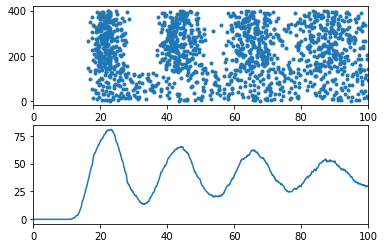

In [222]:
net.run(duration)

subplot(211)
plot(M.t/ms, M.i, '.')
xlim(0, duration/ms)

subplot(212)
plot(LFP.t/ms, LFP.smooth_rate(window='flat', width=10*ms)/Hz)
xlim(0, duration/ms)

show()

In [223]:
find_min_max(4)

([80.44554455445544, 79.70297029702971, 75.74257425742574, 74.25742574257426],
 [13.366336633663366,
  14.85148514851485,
  16.336633663366335,
  19.05940594059406])